In [11]:
#this part creates a sheet 'prot_functions.xlsx' whith every gene of the screen and their associated catogory 
#from the prot_categoies 'prot_categories.xlsx' sheet
import pandas as pd 

# load results sheet
df_descriptions = pd.read_excel('MS_results.xlsx')

# create the DataFrame that will get the proteins and their functions
df_prot_functions = pd.DataFrame()
df_prot_functions['Symbol'] = df_descriptions['Symbol']
df_prot_functions['Function'] = '~none'

# load the prot categories as an excel file
xls_combined = pd.ExcelFile('prot_categories.xlsx')

# order sheets
ordered_sheets = ['kinases phosphatases GAP',
                  'adhesion', 
                  'cytoskeleton', 
                  'transport', 
                  'translation', 
                  'proteasome',
                  'mitochondria']

# this loop gives the category to each prot that has one
for sheet_name in ordered_sheets:
    df = pd.read_excel(xls_combined, sheet_name=sheet_name)
    prots = df['Symbol']
    for prot in prots:
        if df_prot_functions.loc[df_prot_functions['Symbol'] == prot, 'Function'].item() == '~none':
            df_prot_functions.loc[df_prot_functions['Symbol'] == prot, 'Function'] = sheet_name

# save 
writer = pd.ExcelWriter('prot_functions.xlsx', engine='openpyxl')
df_prot_functions.to_excel(writer, index=False)
writer.save()


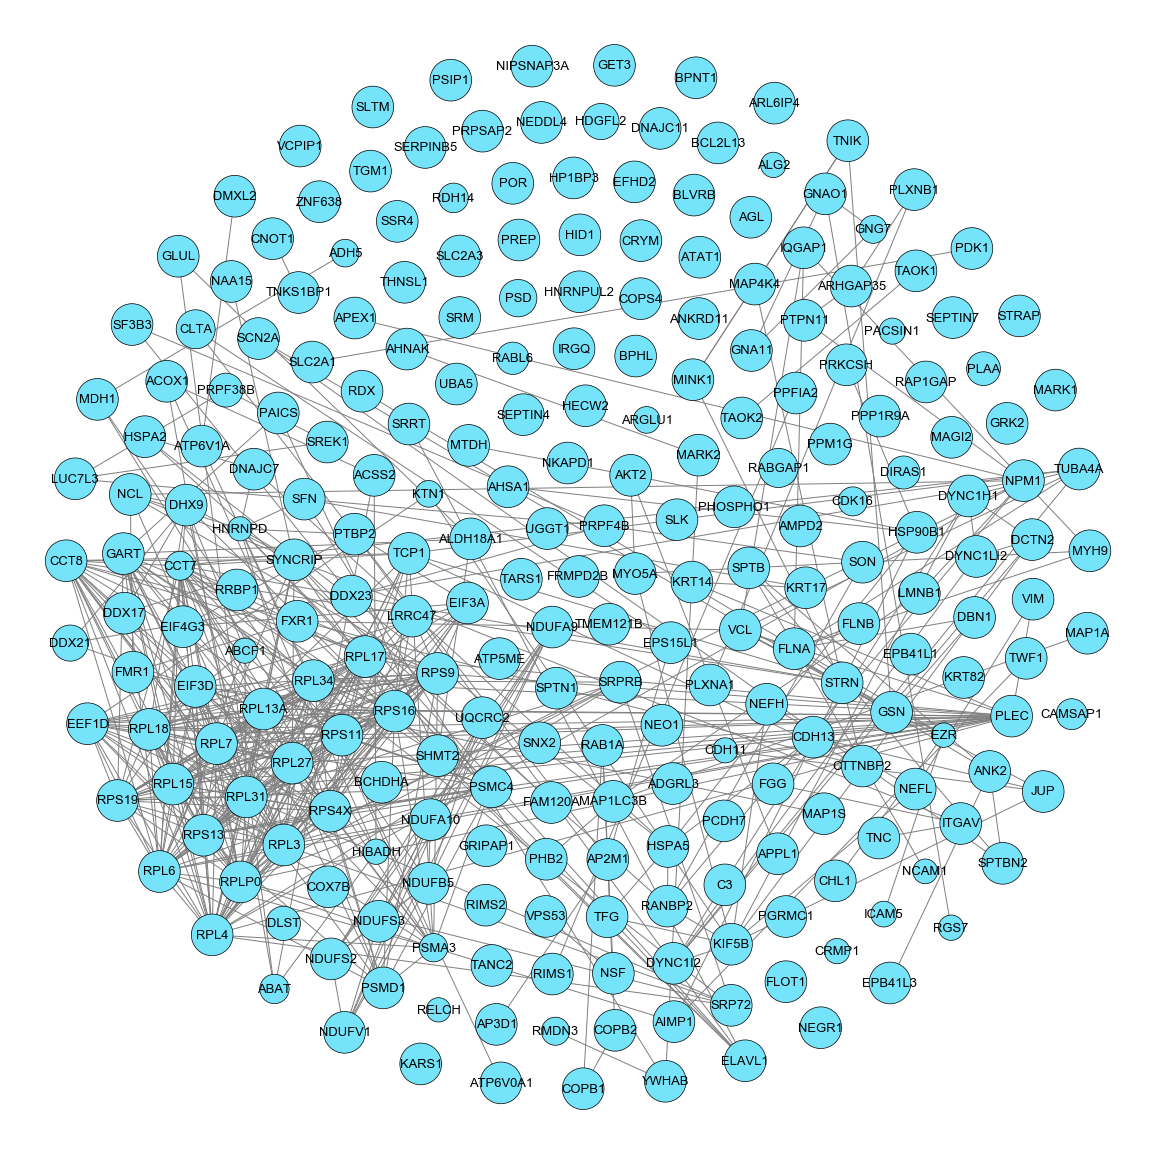

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.patches as mpatches
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'

# Charger les données depuis le fichier Excel
df = pd.read_excel('string_interactions_human.xlsx')

# Créer un graphe à partir des données
G = nx.from_pandas_edgelist(df, 'node1', 'node2')

# Calculate the degree of each node
degrees = dict(G.degree())

# Charger les ratios depuis le fichier Excel
df_ratios = pd.read_excel('MS_results.xlsx')
ratios = df_ratios.set_index('Symbol')['Ratio'].to_dict()

#ajouter les protéines sans lien dans le graphe
proteins = df_ratios['Symbol'].unique().tolist()
proteins.remove('FRMPD2B-HA')
for protein in proteins:
    if protein not in G.nodes:
        G.add_node(protein)
# Liste de nœuds à enlever
nodes_to_remove = [node for node in G.nodes if node not in proteins]

# Supprimer les nœuds de la liste
G.remove_nodes_from(nodes_to_remove)


# Normaliser les ratios pour qu'ils soient tous compris entre 0 et 5
for node, ratio in ratios.items():
    if ratio > 5:
        ratios[node] = 5

# Charger les catégories depuis le fichier Excel
df_categories = pd.read_excel('prot_functions.xlsx')
categories = df_categories.set_index('Symbol')['Function'].to_dict()

# Nombre de cercles
n = 9



# Attribuer à chaque catégorie une couleur unique
colors = sns.color_palette("pastel", len(set(categories.values())))
categories_colors = {category: colors[i] for i, category in enumerate(set(categories.values()))}


# Calculer le nombre total de positions nécessaires
total_positions = len(proteins)-1

# Calculer le nombre de positions pour chaque cercle de manière non uniforme
c = 6 # nombre d'élément sur premier cercle
x = (total_positions-n*c)/(n * (n + 1) // 2.7)
positions_per_circle = [int(c+x*i) for i in range(n)]

# Calculer la somme des positions_per_circle sauf le dernier élément
sum_positions = sum(positions_per_circle[:-1])

# Calculer la différence entre total_positions et sum_positions
diff = total_positions - sum_positions

# Remplacer le dernier élément de positions_per_circle par la différence
positions_per_circle[-1] = diff
positions_per_circle[-2]+=1


# Créer une liste de positions pour chaque cercle
circle_positions = []
for i in range(n):
    delay=0.05*(-1)**i
    e = 1.3
    circle_positions.extend([e*(i+1)/n * np.cos(2 * np.pi * j / positions_per_circle[i]+delay), e*(i+1)/n * np.sin(2 * np.pi * j / positions_per_circle[i]+delay)] for j in range(positions_per_circle[i]))

# Convertir les coordonnées cartésiennes en coordonnées polaires
polar_positions = [(np.sqrt(x**2 + y**2), np.arctan2(y, x)) for x, y in circle_positions]

# Trier les positions par rayon, puis par angle
polar_positions.sort(key=lambda pos: (pos[1], pos[0]))
# et être placé en premier, sur le point du milieu


# Convertir les coordonnées polaires en coordonnées cartésiennes
circle_positions = [(r*np.cos(theta), r*np.sin(theta)) for r, theta in polar_positions]


# Trier les nœuds par degré
nodes_sorted_by_degree = sorted(G.nodes, key=lambda node: degrees.get(node, 0))

# Manually order the sheets (same order you've provided before)
ordered_sheets = ['translation','mitochondria',
                  'proteasome',  
                  'transport','adhesion','cytoskeleton', 
                   'kinases phosphatases GAP']

# Assign a priority to each category based on the order
category_priorities = {category: i for i, category in enumerate(ordered_sheets)}

# Change the sorting key to use the category priorities
nodes_sorted_by_category_and_degree = sorted(nodes_sorted_by_degree, key=lambda node: (category_priorities.get(categories.get(node, ''), float('inf')), degrees.get(node, 0)))


# Créer une disposition pour chaque nœud
pos = {}
for i, node in enumerate(nodes_sorted_by_category_and_degree):
        pos[node] = circle_positions[i % len(circle_positions)]


size =21
# Créer une figure avec deux subplots
fig, ax2 = plt.subplots(1, 1, figsize=(size, size)) 

# Définir la taille des nœuds en fonction des ratios
node_sizes = [(ratios.get(node, 0)) **1.2*12*size for node in G.nodes]

# Définir la couleur des nœuds en fonction de leur catégorie
node_colors = [categories_colors.get(categories.get(node, ''), 'black') for node in G.nodes]

# Ajoutez le nœud à votre graphe
G.add_node('FRMPD2B')

# Définir la position du nouveau nœud
pos['FRMPD2B'] = (0, 0)

# Dessiner le graphe avec la disposition obtenue et une couleur unique
nx.draw(G, pos, with_labels=False, node_color='#75e4fa', node_size=node_sizes, edgecolors='black', linewidths=0.7, edge_color='gray', nodelist=proteins, ax=ax2)

# Ajuster les labels 
for node, (x, y) in pos.items():
    ax2.text(x, y, node, fontsize=13, va='center', ha='center', fontname='Arial')

# Dessinez le nœud 'FRMPD2B-HA' avec une couleur et une taille spécifiques.
nx.draw_networkx_nodes(G, pos, nodelist=['FRMPD2B'], node_color='#75e4fa', node_size=5**1.2*12*size, edgecolors='black',linewidths=0.7, ax=ax2)

    
# Mettre à l'échelle les axes de manière égale pour le premier subplot
ax2.set_aspect('equal')

# Sauvegarder la figure
plt.savefig("graph_String_MS.pdf", format='pdf', transparent=True)

# Afficher la figure
plt.show()



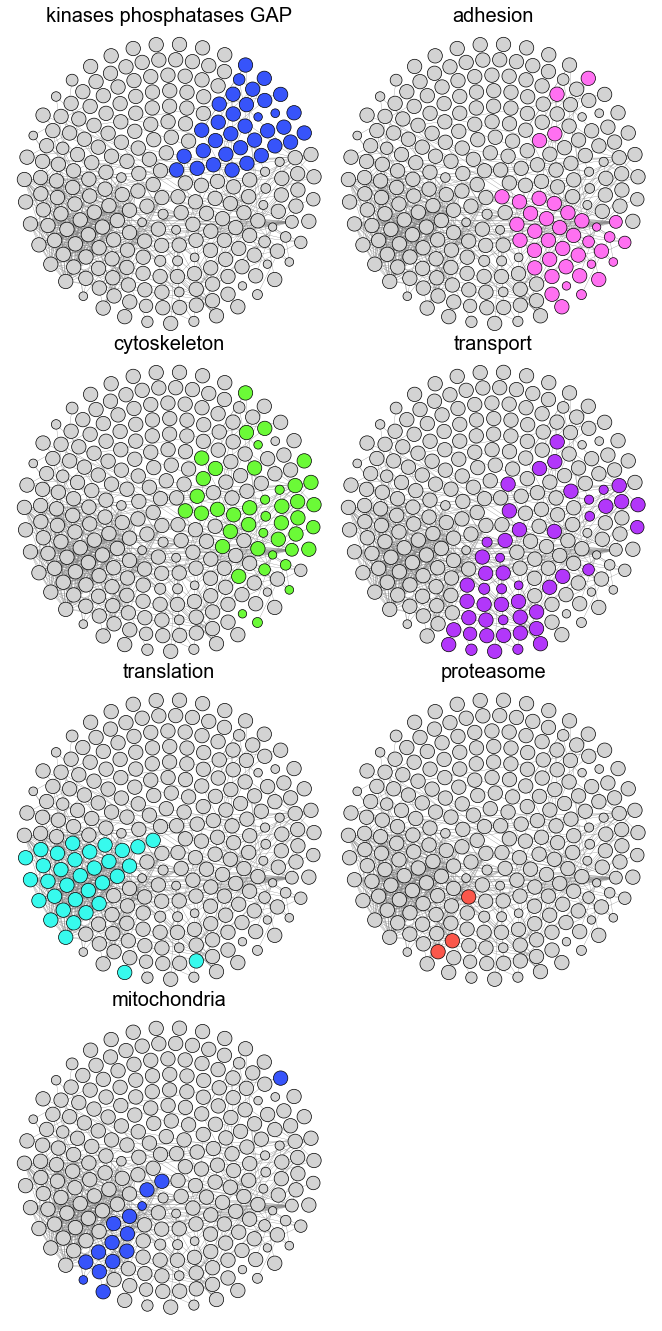

In [13]:
import math
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'


# Charger le fichier Excel avec plusieurs feuilles
xls = pd.ExcelFile('prot_categories.xlsx')

# Créer votre propre palette de couleurs
rouge = "#fa574b"
vert = "#6bfa37"
violet = "#b237fa"
cyan = "#37faed"
rose = "#ff70f1"
bleu = "#3754fa"

colors = [bleu, rose, vert, violet, cyan, rouge ]
sheet_colors = {sheet_name: colors[i % len(colors)] for i, sheet_name in enumerate(xls.sheet_names)}



# Définir le nombre de colonnes pour les subplots
cols = 2

# Déterminer le nombre de rangées pour les subplots
rows = math.ceil(len(xls.sheet_names) / cols)

size = 5
# Créer une figure et un ensemble de subplots
fig, axs = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
plt.subplots_adjust(wspace=0.0, hspace=0.05, left=0.05, right=0.95, bottom=0.05, top=0.95)

# Parcourir chaque feuille dans le fichier Excel
for i, sheet_name in enumerate(xls.sheet_names):
    # Charger la feuille actuelle dans un DataFrame
    df = pd.read_excel(xls, sheet_name=sheet_name)

    # Obtenir la liste des gènes à partir de la colonne 'Symbol'
    genes = df['Symbol'].unique()

    # Déterminer l'axe actuel
    ax = axs[i // cols, i % cols]

    # Définir la couleur des nœuds en fonction de leur appartenance à la liste de gènes
    node_colors = [sheet_colors[sheet_name] if node in genes else 'lightgray' for node in G.nodes]
    # Définir la taille des nœuds en fonction des ratios
    node_sizes = [ratios.get(node, 0) **1.2*6*size for node in G.nodes]
    # Dessiner le graphe avec la disposition obtenue
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=node_sizes, edgecolors='black',width=0.3,  linewidths=0.7, edge_color='gray', ax=ax)

    # Ajouter un titre à la figure
    ax.set_title(sheet_name, fontsize=20, fontname='Arial')

# Pour éliminer les subplots vides si le nombre total de feuilles n'est pas un multiple de 3
for j in range(i+1, rows*cols):
    fig.delaxes(axs.flatten()[j])

# Sauvegarder la figure
plt.savefig(f"subplots_categories.pdf", format='pdf', transparent=True)

# Afficher la figure
plt.show()


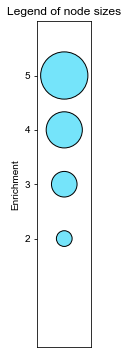

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6))

# Définir les enrichissements
enrichments = [2, 3, 4,5]

# Définir la taille des nœuds en fonction des enrichissements
node_sizes = [enrichment**1.2*12*21 for enrichment in enrichments]

# Créer les cercles
for i in range(len(enrichments)):
    circle = plt.Circle((0.5, enrichments[i]), node_sizes[i]/4000, edgecolor='black', facecolor='#75e4fa', alpha=1)
    ax.add_patch(circle)

# Définir l'axe y
ax.set_yticks(enrichments)
ax.set_yticklabels(enrichments)

# Définir l'axe x
ax.set_xticks([])

# Définir les limites du diagramme
ax.set_ylim(0, 6)
ax.set_xlim(0, 1)

# Mettre à l'échelle les axes de manière égale
ax.set_aspect('equal')

# Afficher le diagramme
plt.title('Legend of node sizes')
plt.ylabel('Enrichment')

plt.savefig(f"legendSize.pdf", format='pdf', transparent=True)
plt.show()

